# Setup Environment, Load Data

In [1]:
import smtplib
from email.mime.text import MIMEText
import constants

# Email configuration
SMTP_SERVER = "smtp.gmail.com"  # For Gmail, change if using Outlook or another service
SMTP_PORT = 465  # SSL port (or use 587 for TLS)
SENDER_EMAIL = "abhaymathur1000@gmail.com"  # Replace with your email
SENDER_PASSWORD = constants.EMAIL_PASSWORD  # Replace with your email password
RECEIVER_EMAIL = "abhaymathur1000@gmail.com"  # Your email (or another recipient)

def send_email(subject, body=""):
    """Sends an email notification"""
    msg = MIMEText(body)
    msg["Subject"] = subject
    msg["From"] = SENDER_EMAIL
    msg["To"] = RECEIVER_EMAIL

    try:
        with smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT) as server:
            server.login(SENDER_EMAIL, SENDER_PASSWORD)
            server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())
        print("Email sent successfully!")
    except Exception as e:
        print(f"Error sending email: {e}")



# Notify when the script completes
# send_email("✅ Script Completed", "Your Python script has finished running.")


In [2]:
#Import Libraries
import os
import json
import csv
import matplotlib.pyplot as plt
import sklearn
import tensorflow
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import re
import torch
import torch.nn as nn
import time
import spacy
import kagglehub

#NLP Packages
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
from IPython.display import display, clear_output
import pyarrow
import fastparquet

2025-02-25 12:44:10.840121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740516251.005121   26839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740516251.053879   26839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 12:44:11.447556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/abhaydesktop/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarni

In [3]:
if os.path.exists("/kaggle"):
    path = "/kaggle/input/yelp-dataset"
elif os.path.exists('/home/abhaydesktop/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4'):
    path = '/home/abhaydesktop/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4'
else:
    path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
print("Path to dataset files:", path)



def load_data(path, filename, chunk_size=10000):
    chunks = pd.read_json(os.path.join(path, filename), lines=True, chunksize=chunk_size)

    df_list = []

    for chunk in chunks:
        df_list.append(chunk)


    return pd.concat(df_list, ignore_index=True)



print("\nDataset Load Times:\n")
start_time = time.time()
businesses_df = load_data(path, "yelp_academic_dataset_business.json")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Business Load Time: {elapsed_time:.4f} seconds")

# start_time = time.time()
# tips_df = load_data(path, "yelp_academic_dataset_tip.json")
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Tips Load Time: {elapsed_time:.4f} seconds")

start_time = time.time()
reviews_df = load_data(path, "yelp_academic_dataset_review.json")
# num_rev_load = 2000000
num_rev_load = 100000000
if num_rev_load < len(reviews_df):
    reviews_df = reviews_df.sample(n=num_rev_load)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Review Load Time: {elapsed_time:.4f} seconds")



Path to dataset files: /home/abhaydesktop/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4

Dataset Load Times:

Business Load Time: 2.3802 seconds
Review Load Time: 77.1132 seconds


In [4]:
#Filter out Data that Belongs to Businesses Under a Certain Threshold
minimum_business_reviews = 30
reviews_df = reviews_df[reviews_df['business_id'].map(reviews_df['business_id'].value_counts()).gt(minimum_business_reviews)]

#Create Merged DataFrame of Remaining Reviewed Businesses, and Split Categories into List
df_rb = pd.merge(reviews_df, businesses_df, on="business_id")
df_rb['categories'] = df_rb['categories'].str.split(", ")

#Print Metrics
print(f"\nNumber of Total Businesses Represented: {len(df_rb['business_id'].unique())}")
print(f"Number of Total Reviews: {len(df_rb)}")
print(f"Percentage of Reviews Kept: {len(df_rb)/num_rev_load*100}%")


Number of Total Businesses Represented: 45426
Number of Total Reviews: 5705293
Percentage of Reviews Kept: 5.705293%


# Note still using old manually loaded data

# Analyze data

Answer the questions: 

* What is the distribution of reviews over time
* What is the range of reviews for different businesses over time
* How does covid closures and can we kick those out
* Do we predict sentiment separately or do we have one big model? Now, looking more at predicting sentiment. Then sentiment + other things for closure. But this is still on the table
* What output do we want for sentiment analysis? Ordinal classification? Specific words?
* How would we output sentiment for different years? How do we equalize different amount of years data
* How to classify closure. When the last review happened, when a certain threshold of reviews happened. What about renovations, etc. how do we determine the closure
* Do research on how to deal with time data, what models we can use, etc.
* Explore location data. See if a lot of places are close to each other, what is avg distance, etc. Clustering analysis for points, heatmap. Maybe see what location data is relevant in closures


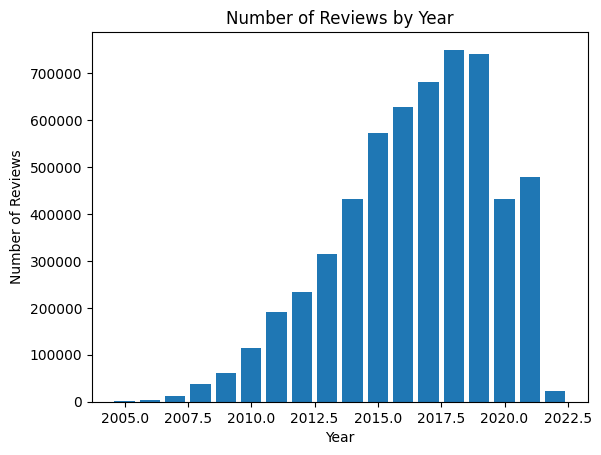

In [5]:
year_count = reviews_df["date"].dt.year.value_counts().sort_index()
plt.bar(year_count.index, year_count.values)
plt.title("Number of Reviews by Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

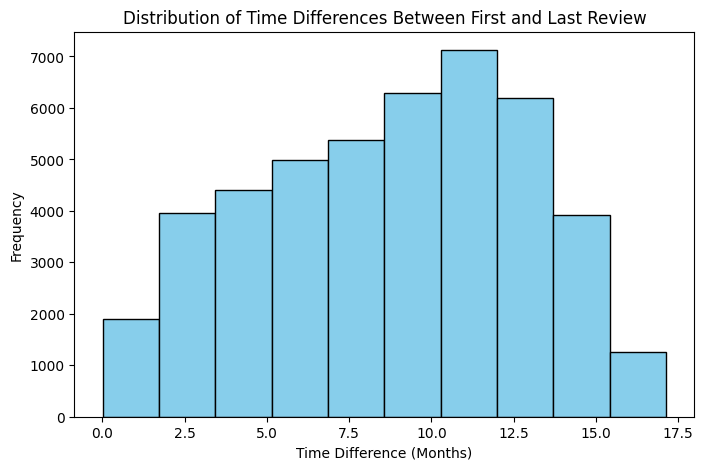

In [ ]:
# Convert review_date to datetime
df_rb['date'] = pd.to_datetime(df_rb['date'])

# Calculate the difference in time between the first and last review for each business
time_diffs = df_rb.groupby('business_id')['date'].agg(['min', 'max'])
time_diffs['time_diff'] = (time_diffs['max'] - time_diffs['min']).dt.days
time_diffs['time_diff_years'] = time_diffs['time_diff'] / 30 / 12

# Create a bar plot showing the frequency of time differences
plt.figure(figsize=(8, 5))
plt.hist(time_diffs['time_diff_years'], bins=10, color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Time Difference (Years)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences Between First and Last Review')

# Show plot
plt.show()



# Should we do one model or two model?

Two step model:
Pros:
* More interperetable
* Easier to debug
Cons:
* Loss of information, nuances
* Introduce bias/error in sentiment analysis part

Direct end-to-end:
Pros:
* Avoids cons of two step model
* Direct relationship
Cons:
* More training data to learn complex associations
* Less interpretability compared to two step model


Conclusion:
* I think we should go with end-to-end. We have the training data
* We can use Bert to deal with text data, then combine that with a standard MLP for the other data
* Combine the outputs in another MLP for the output


# What output/input do we want for end-to-end model?

Input: Reviews with a timestamp. Perhaps we have to summarize reviews or somehow reduce many reviews into a core few to stay within the token limit

Output: Ordinal classification of "In how many years (or months) will this place close". Not close being infinity


# Making the dataset

Would have to make a dataset of businesses that closed and one that is still open

# How do we classify closure?

Is it when a last review has been made, when reviews trickle down, etc.

It seems like the distribution of reviews is dependent sometimes normal/gaussian, but sometimes sporadic

There is a good amount of businesses that end before {cutoff_year} and after it so training data would be decent

I propose instead of predicting how far in the future a business will close, we just predict whether it will close after {cutoff_year}. 2020 is a good year to do it because right before COVID, and 17% close

# Proposed problem

Given a random sample of {X} reviews up to 6 months before {cutoff_date}, will the business survive continue to have reviews after the cutoff_date

# Data Using

* Use each review, but don't include the time of the review
    * If it sees many old reviews, it will think the business closed
* Use other statistics like location, proximity to other businesses, etc.
* Use derived stats like time between reviews, etc. number of reviews, etc.

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


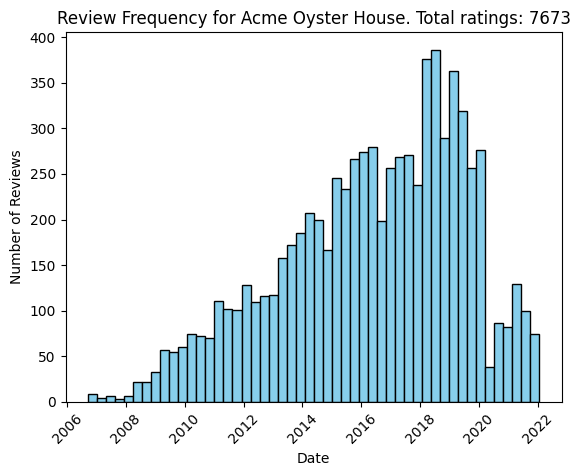

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


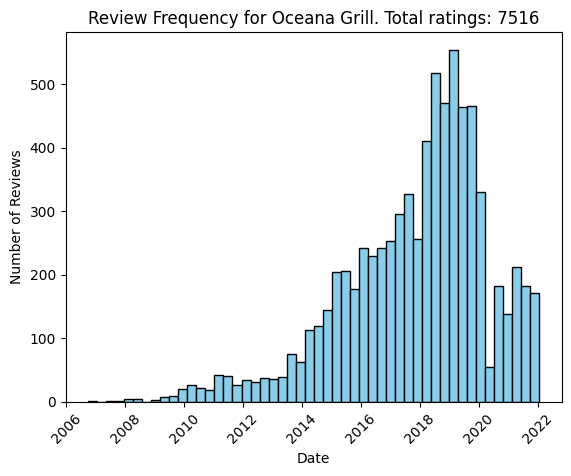

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


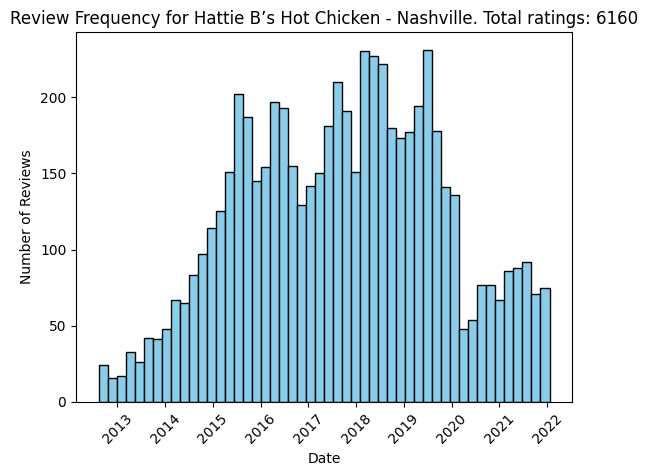

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


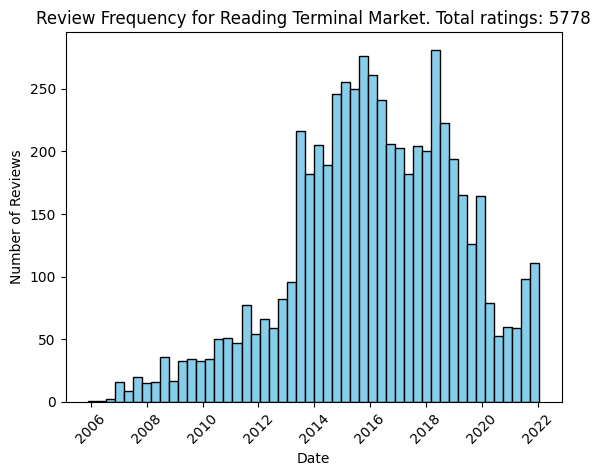

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


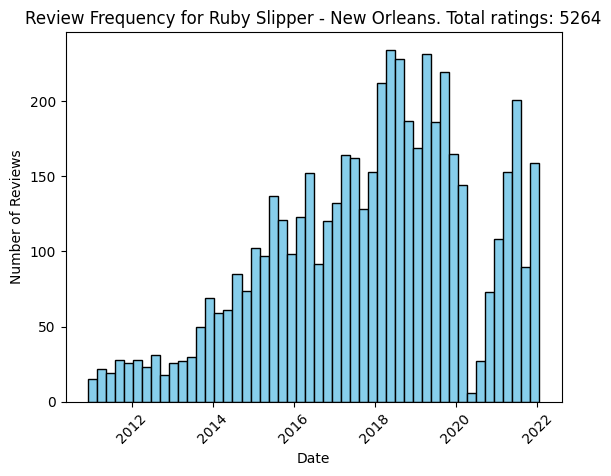

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


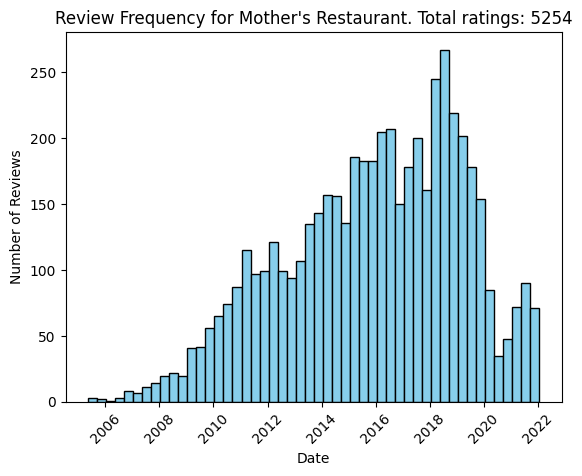

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


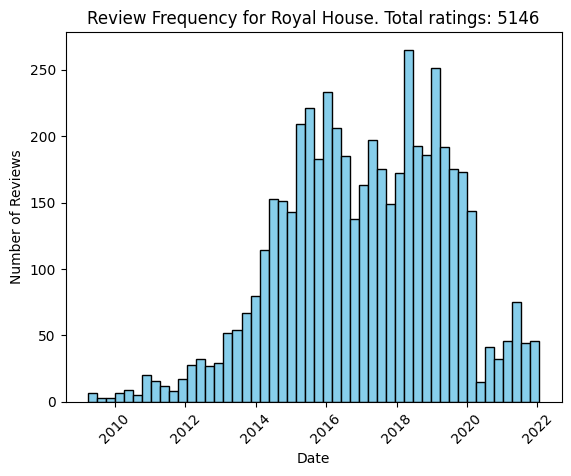

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


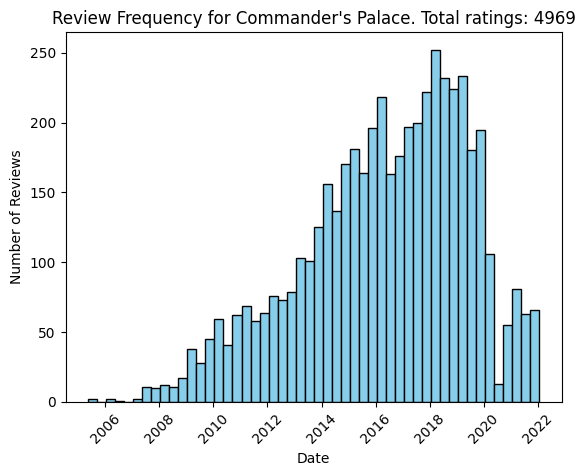

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


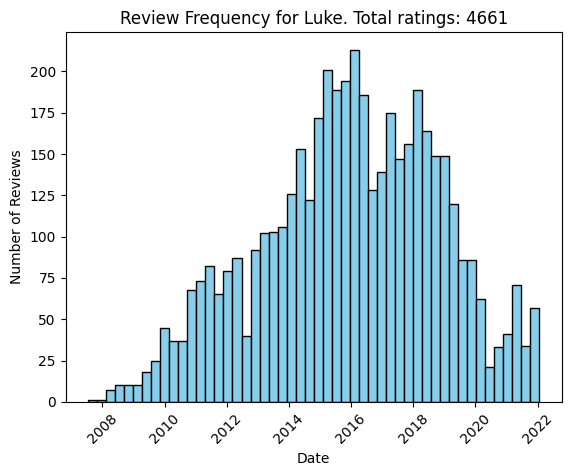

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


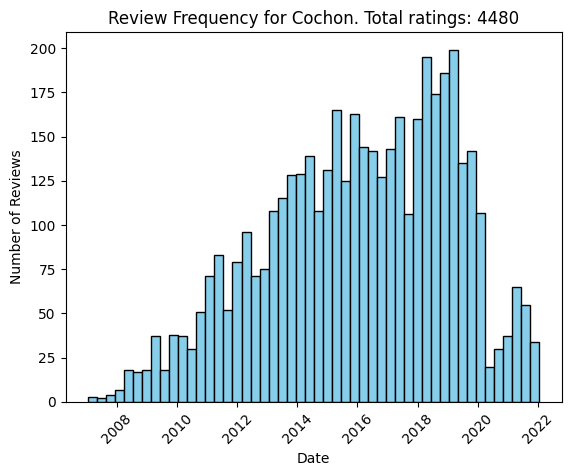

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


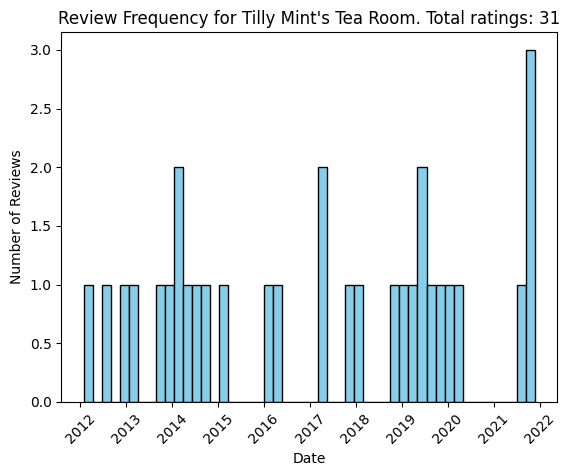

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


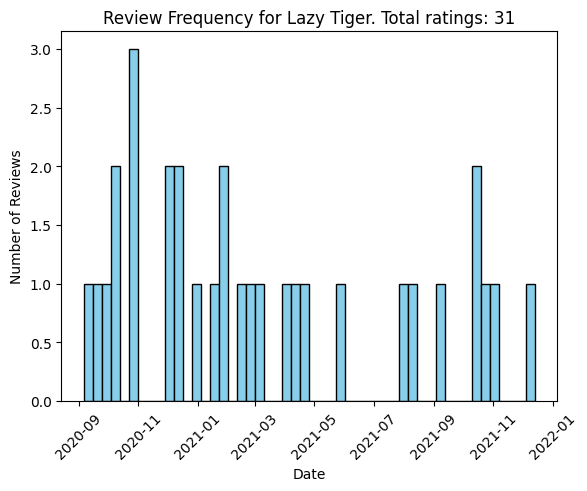

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


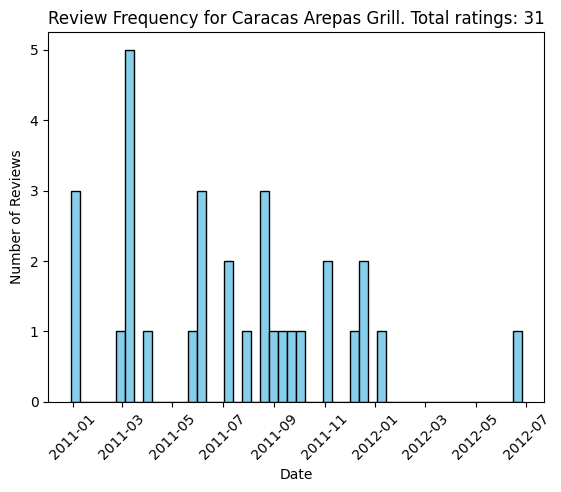

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


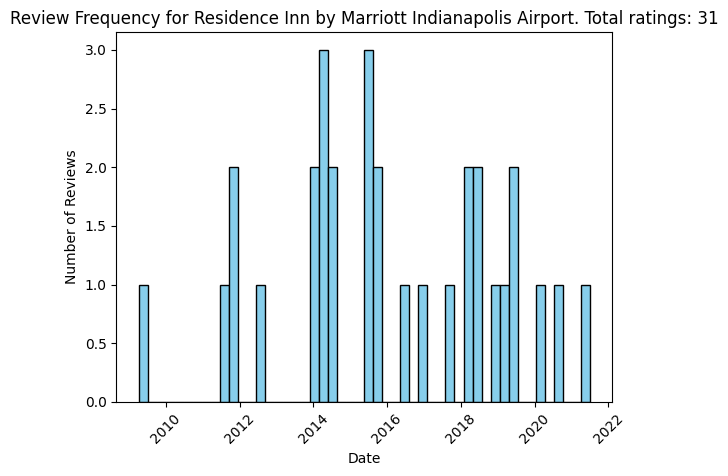

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


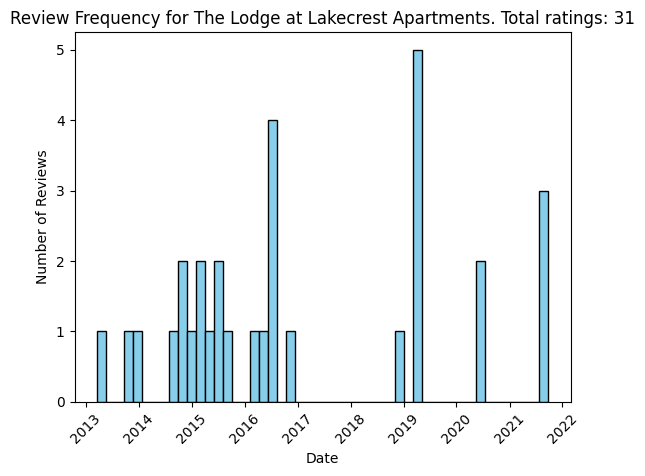

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


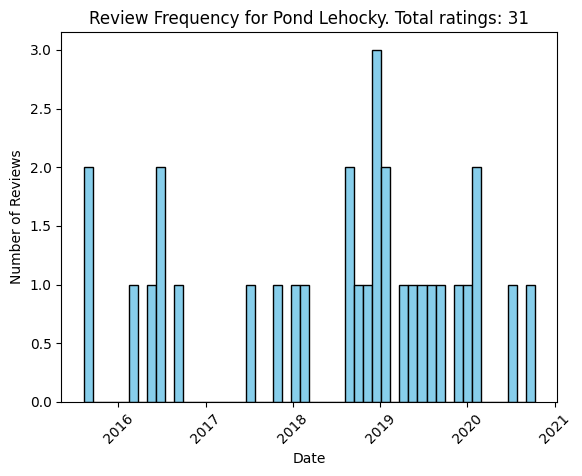

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


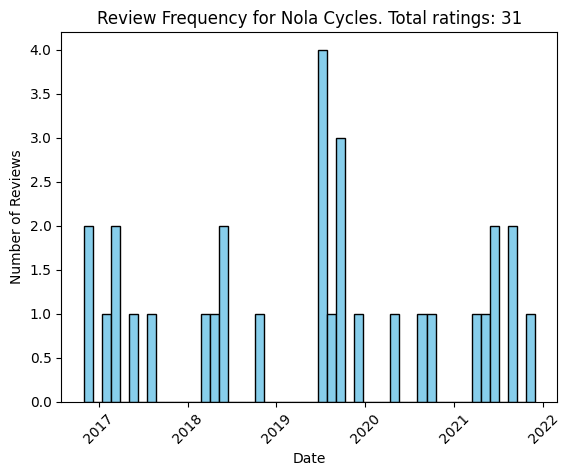

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


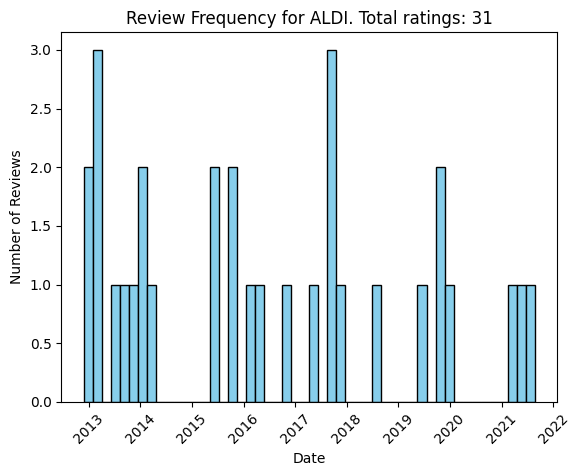

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


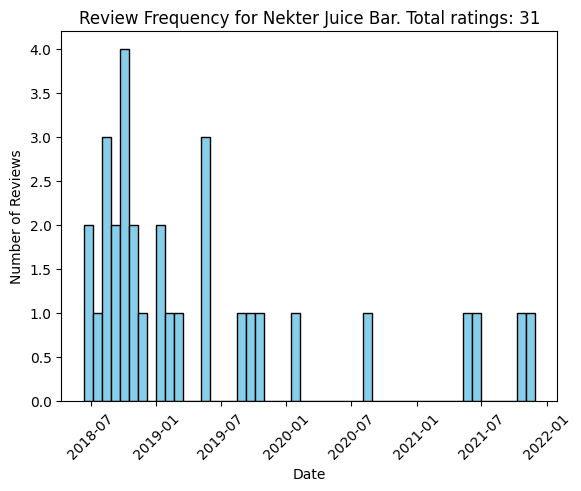

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


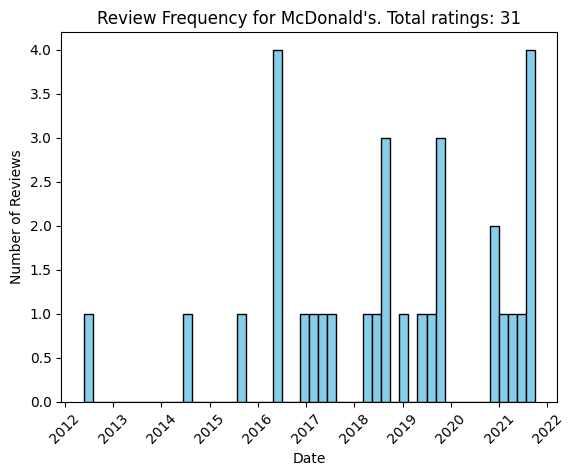

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


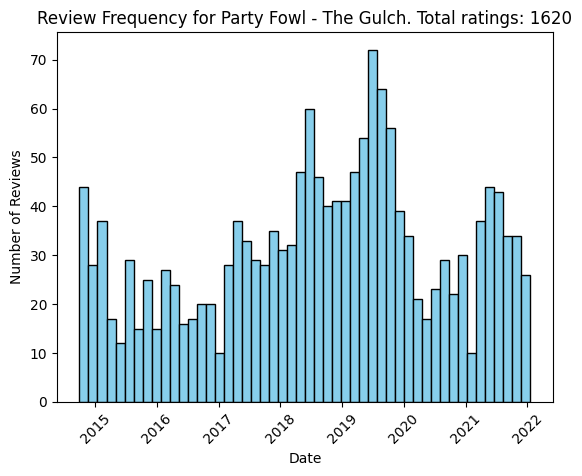

In [7]:
# Plotting the distribution of either most or least reviewed businesses over time

def plot_dist_of_reviews(business_id):
    business_name = businesses_df[businesses_df['business_id'] == business_id]['name'].values[0]

    business_reviews = df_rb[df_rb['business_id'] == business_id]
    business_reviews['date'] = pd.to_datetime(business_reviews['date'])
    business_reviews = business_reviews.sort_values('date')
    total_business_reviews = business_reviews.shape[0]

    plt.hist(business_reviews['date'], bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Review Frequency for {business_name}. Total ratings: {total_business_reviews}")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.show()

top_businesses = df_rb.groupby('business_id').size().sort_values(ascending=False).head(10)

for i in range(10):
    plot_dist_of_reviews(top_businesses.index[i])

bottom_businesses = df_rb.groupby('business_id').size().sort_values(ascending=False).tail(10)

for i in range(10):
    plot_dist_of_reviews(bottom_businesses.index[i])


average_size = int(df_rb.groupby('business_id').size().sort_values(ascending=False).mean())
average_business_id = df_rb.groupby('business_id').size().sort_values(ascending=False).index[average_size]
plot_dist_of_reviews(average_business_id)

# plot_dist_of_reviews(top_business_id)
# plot_dist_of_reviews(bottom_business_id)

# Analyze data

Answer the questions: 

* What is the distribution of reviews over time
* What is the range of reviews for different businesses over time
* How does covid closures and can we kick those out
* Do we predict sentiment separately or do we have one big model? Now, looking more at predicting sentiment. Then sentiment + other things for closure. But this is still on the table
* What output do we want for sentiment analysis? Ordinal classification? Specific words?
* How would we output sentiment for different years? How do we equalize different amount of years data
* How to classify closure. When the last review happened, when a certain threshold of reviews happened. What about renovations, etc. how do we determine the closure
* Do research on how to deal with time data, what models we can use, etc.
* Explore location data. See if a lot of places are close to each other, what is avg distance, etc. Clustering analysis for points, heatmap. Maybe see what location data is relevant in closures


In [ ]:
cutoff_year = 2020


df_rb['date'] = pd.to_datetime(df_rb['date'])

businesses_with_reviews_after_year = df_rb[df_rb['date'] >= f'{cutoff_year}-01-01']['business_id'].unique()


reviews_with_no_reviews_after_year = df_rb[~df_rb['business_id'].isin(businesses_with_reviews_after_year)]

businesses_with_no_reviews_after_year = reviews_with_no_reviews_after_year['business_id'].unique()

reviews_with_no_reviews_after_year

print(f"Number of businesses with reviews after {cutoff_year}:", len(businesses_with_reviews_after_year))
print(f"Number of businesses with no reviews after {cutoff_year}:", len(businesses_with_no_reviews_after_year))
print("Total number of businesses:", len(df_rb['business_id'].unique()))
print("Ratio of businesses that close: ", len(businesses_with_no_reviews_after_year) / len(df_rb['business_id'].unique()))

Number of businesses with reviews after 2020: 38506
Number of businesses with no reviews after 2020: 6920
Total number of businesses: 45426
Ratio of businesses that close:  0.1523356667987496


/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


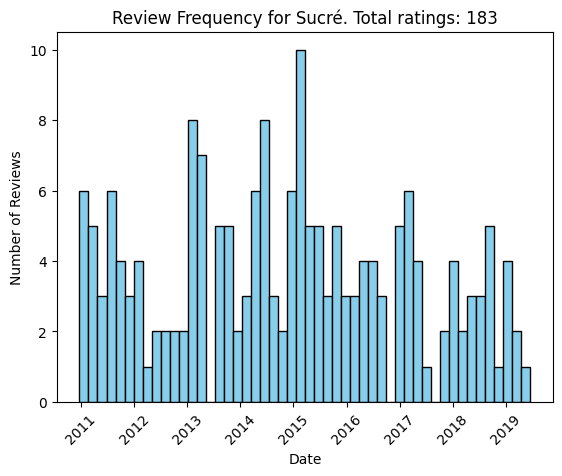

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


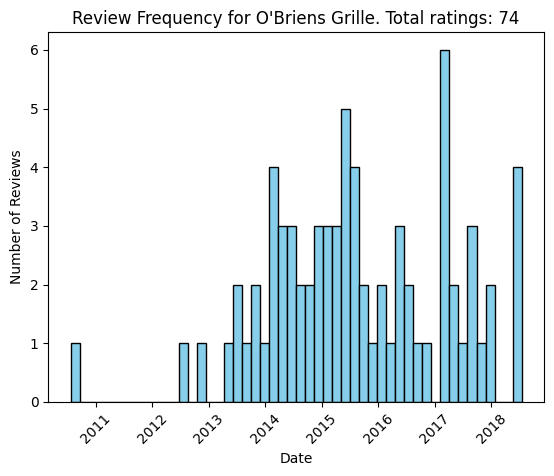

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


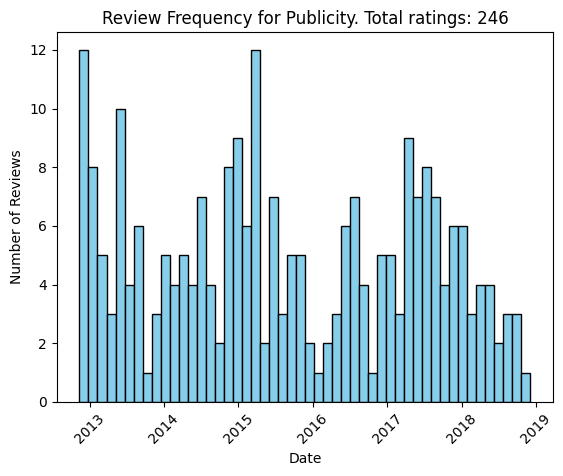

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


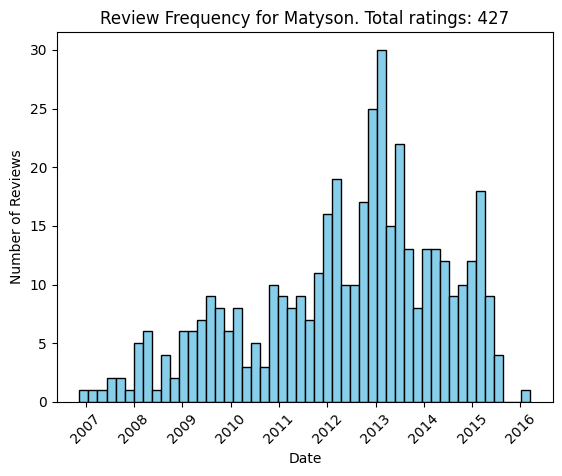

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


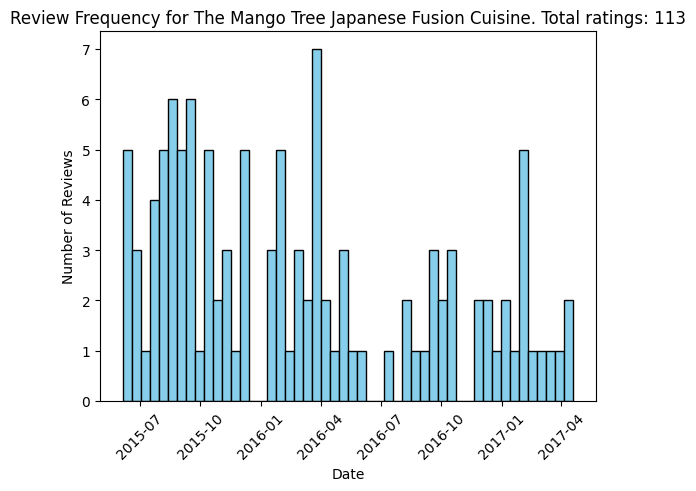

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


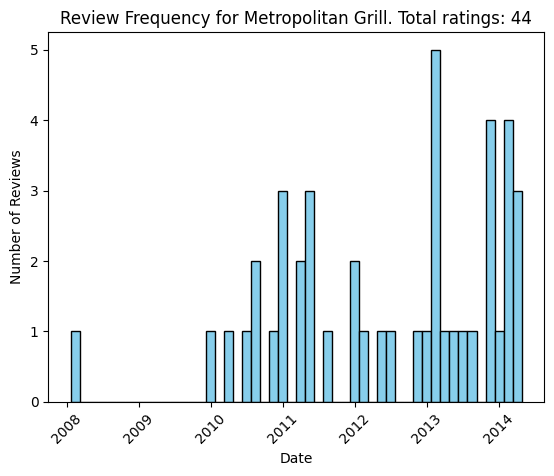

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


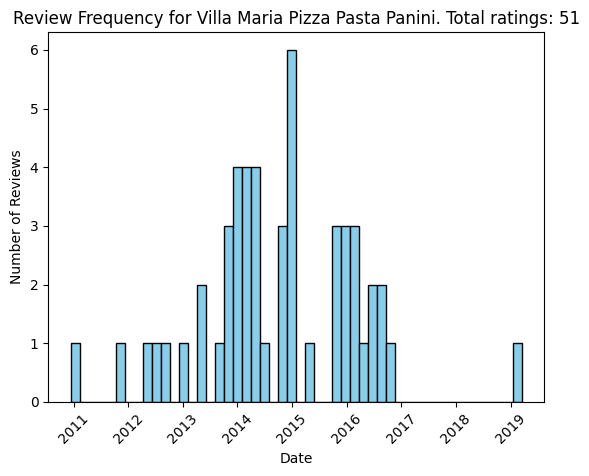

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


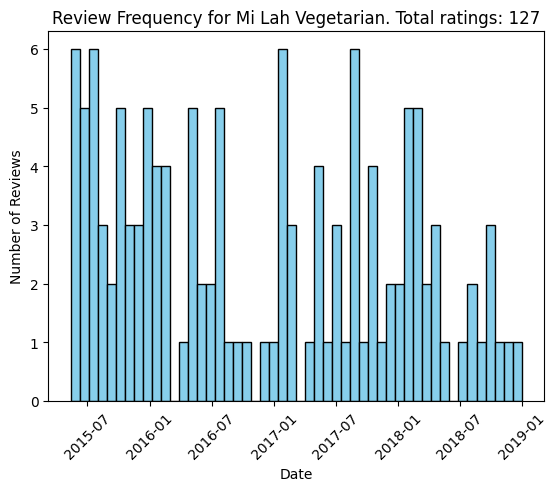

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


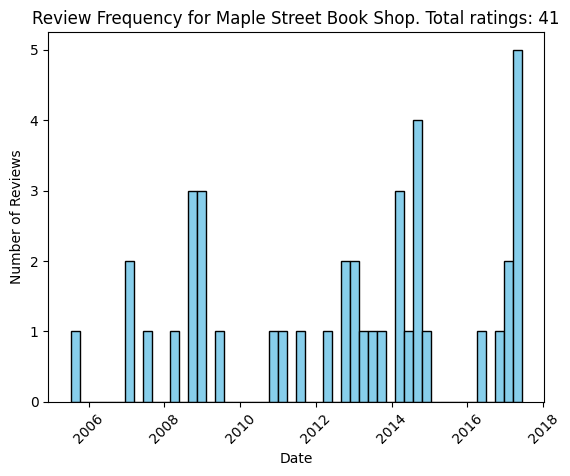

/tmp/ipykernel_26839/2076074938.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_reviews['date'] = pd.to_datetime(business_reviews['date'])


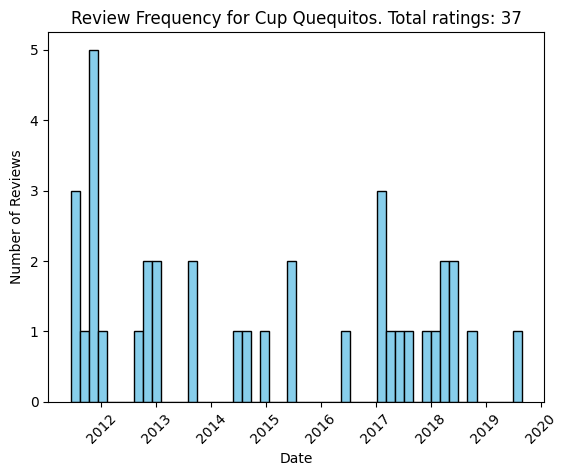

: 

In [ ]:
for i in range(10):
    random_business_id = random.choice(reviews_with_no_reviews_after_year['business_id'].unique())

    plot_dist_of_reviews(random_business_id)